# Community Detection Lab (week 1)
Tasks: https://goo.gl/40VHTW  
Slides for the week 1: https://goo.gl/iFBYmV

## Import of python-igraph and graph loading

In [1]:
# Impor python-igraph library
import igraph
print(igraph.__version__)

0.7.1


In [2]:
# Load the input graph (email graph https://goo.gl/j5rHmz in NCOL format
# converted from http://www.cc.gatech.edu/dimacs10/archive/data/clustering/email.graph.bz2, which was in Metis format) 
with open('email.ncol', 'r') as finp:
    g = igraph.Graph.Read_Ncol(finp, weights=False, directed=False)
igraph.summary(g)

IGRAPH UN-- 1133 5451 -- 
+ attr: name (v)


## Task 2.1. Find all maximal 4-cliques

In [3]:
# Find all maximal 4-cliques
cxliques4 = g.maximal_cliques(4)
print('Found {} maxial 4-cliques having sizes:'.format(len(cxliques4)))

Found 867 maxial 4-cliques having sizes:


In [4]:
# Print sizes in a friendly way, counting the number of cliques of each size
def cliqsBySize(cliques):
    '''Goup cliques by size

    cliques  - cliques to group them by size
    return  groups of cliques by size
    '''
    cqsizes = {}
    for cx in cliques:
        cxsz = len(cx)  # Size of the clique
        cqsizes[cxsz] = cqsizes.get(cxsz, 0) + 1
    return cqsizes
    
# Display sizes of the maximal 4-cliques ordered by size
print(','.join([' {} ({} cliques)'.format(cxsz, cxnum) for cxsz, cxnum in cliqsBySize(cxliques4).items()]))

 4 (545 cliques), 5 (222 cliques), 6 (69 cliques), 7 (21 cliques), 8 (8 cliques), 9 (1 cliques), 12 (1 cliques)


## Task 2.2. Find all largest cliques

In [5]:
# Find all largest cliques and display their sizes
cl4s = g.largest_cliques()
print('Found {} largest 4-cliques: '.format(len(cl4s)), end='')
print(','.join([' {} ({} cliques)'.format(cxsz, cxnum) for cxsz, cxnum in cliqsBySize(cl4s).items()]))

Found 1 largest 4-cliques:  12 (1 cliques)


In [6]:
# List internal indices of the vertices (not the loaded ids) of the first largest clique with their degrees
print(', '.join(['{}(deg: {})'.format(vid, g.degree(vid)) for vid in cl4s[0]]))

794(deg: 12), 213(deg: 28), 228(deg: 28), 271(deg: 23), 296(deg: 20), 455(deg: 35), 527(deg: 33), 792(deg: 12), 708(deg: 15), 777(deg: 13), 791(deg: 12), 793(deg: 11)


In [7]:
# Visualize found largest clique
# 1. Select found clique as a sequence of vertices from the graph to map internal ids into the loaded ids (names)
seq = g.vs.select(cl4s[0])
# 2. Select a subgraph using the sequence of vertices
subg = seq.subgraph()
# 3. Display the subgraph with green color using input node ids (names) as vertices labels
subg.vs["label"] = subg.vs["name"]
subg.vs['color'] = 'green'
# Save visualization to the specified file
subgimg = 'email_largest_clq.png'

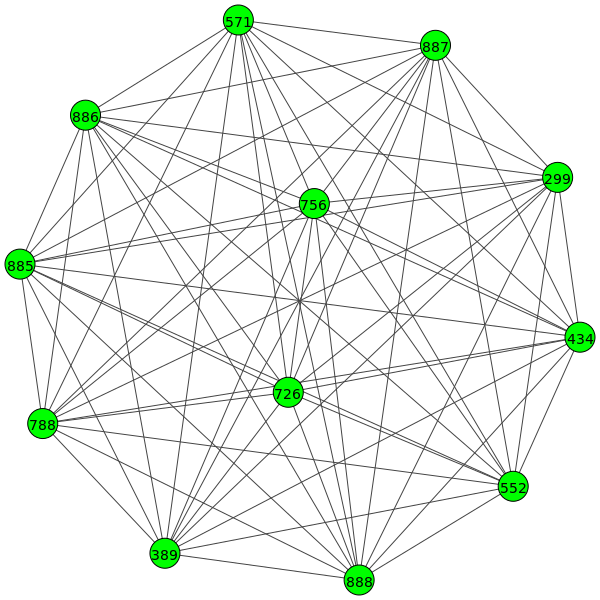

In [8]:
from IPython.display import Image
# Display the visualization
Image(filename=subgimg) 

## Additional Visualization excercises

In [24]:
# Visualize all maximal 4-cliques in the whole graph
clvids = set()  # INternal indices of the member vertices of the 4-cliques
for cx4 in cxliques4:
    clvids = clvids.union(cx4)
# Mark vertices belonging to the maximal 4-cliques with yellow and remained vertices with red
g.vs["color"] = ['yellow' if v.index in clvids else 'red' for v in g.vs]
# Mark vertices in the largest clique with green
g.vs.select(cl4s[0])["color"] = "green"
# Set size of the vertex equal to the vertex degree incremented by 2
g.vs["size"] = [deg+2 for deg in g.vs.degree()]

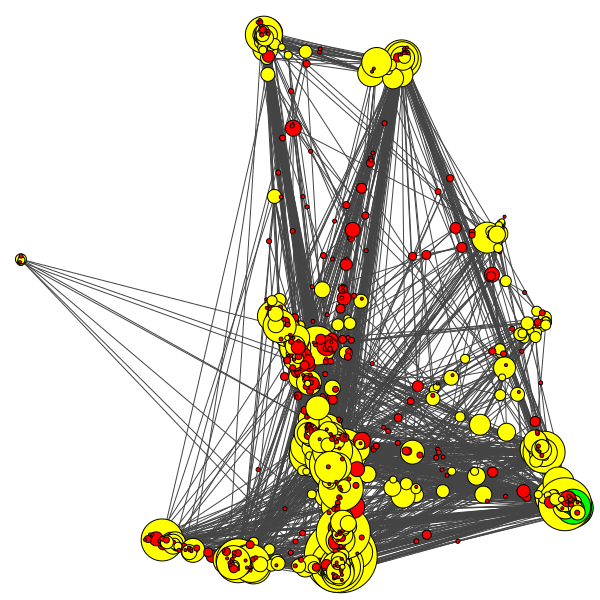

In [25]:
#igraph.plot(g, layout=layout)
gimg = "email_cm4.png"
# Visualize the graph using smaller size of the vertices
igraph.plot(g, target=gimg)  # , vertex_size=6
Image(gimg)

In [19]:
# Print vertices having maximal degree
maxdeg = g.maxdegree()
mxdvnames = g.vs.select(_degree = maxdeg)["name"]
print('{} graph vertices having the maximal degree {}: {}'.format(len(mxdvnames), maxdeg, ', '.join(mxdvnames)))

1 graph vertices having the maximal degree 71: 105


## Task 2.3. Find all 4-clique chains

In [12]:
# Find all 4-cliques
cqs4 = g.cliques(4, 4)
print("The graph contains {} 4-cliques".format(len(cqs4)))

The graph contains 3419 4-cliques


In [13]:
# 4-clique chains consist of all 4-cliques having at least 3 vertices in common, detect such cliques
# 1. Extend 4-cliques with the chained flag as the second item of the array
cqs4 = [[set(verts), None] for verts in cqs4]

In [14]:
# 2. Traverse all the cliques mark each one whether it is a member of the chains or not
cqs4num = len(cqs4)
for i in range(cqs4num-1):
    smarked = cqs4[i][1]  # The sourceis marked
    for j in range(i+1, cqs4num):
        # Skip already marked cliques
        if smarked and cqs4[j][1]:
            continue
        # Having 3 vertices in common <-> size of the symmetric difference is 2
        if len(cqs4[i][0] ^ cqs4[j][0]) == 2:
            cqs4[i][1] = True
            cqs4[j][1] = True
    if cqs4[i][1] is None:
        cqs4[i][1] = False

### Task 2.3.2 Count the number of 4-cliques included in 4-clique chains

In [15]:
# 3. Count the number of chained cliques
chained = sum([x[1] == True for x in cqs4])
print("{} chained 4-cliques and {} non-chained 4-clques".format(chained, cqs4num - chained))

3393 chained 4-cliques and 26 non-chained 4-clques


### Task 2.3.1 Evalaute the number of vertices in 4-clique chains

In [16]:
# Flatten marked 4-cliques joining unique vertices
chain = set()
for cc in cqs4:
    # Consider only the chain members
    if cc[1]:
        chain = chain | cc[0]
print('{} vertices in 4-clique chains'.format(len(chain)))

517 vertices in 4-clique chains


In [17]:
# Flatten maximal 4 cliques joining unique verties
cx4verts = set()
for cq in cxliques4:
    cx4verts = cx4verts | set(cq)
print('{} vertices in maximal 4-cliques'.format(len(cx4verts)))

571 vertices in maximal 4-cliques
